## Download the required data

In [271]:
# import required packages
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
#from sklearn.metrics import mean_absolute_percentage_error as MAPE
import statsmodels.api as sm
import statsmodels.formula.api as sfa
from statsmodels.tsa.api import ExponentialSmoothing as TES 
from statsmodels.tsa.api import SimpleExpSmoothing as SES
from statsmodels.tsa.api import Holt as DES
import seaborn as sns

# Downloading and Prepping Data 
### Barratt Development PLC, Berkeley Group Holdings, and FTSE

In [272]:
BDEV=yf.download('BDEV.L',start='2019-01-02',end='2021-01-01')
BKG=yf.download('BKG.L',start='2019-01-02',end='2021-01-01')
FTSE=yf.download('^FTSE',start='2019-01-02',end='2021-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Let's take a look at the first five items in our dataset.

In [273]:
BDEV.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,458.000000,465.899994,453.600006,462.200012,419.405884,3619480
2019-01-03,457.299988,473.399994,457.000000,464.299988,421.311401,2651069
2019-01-04,466.700012,474.700012,466.700012,473.500000,429.659607,2708897
2019-01-07,476.399994,482.299988,471.700012,477.000000,432.835541,2857355
2019-01-08,477.799988,487.500000,473.100006,479.299988,434.922607,3758265


In [274]:
BKG.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3441.0,3489.0,3382.0,3463.0,3261.556641,385975
2019-01-03,3423.0,3525.0,3423.0,3477.0,3274.741943,462893
2019-01-04,3514.0,3590.0,3506.0,3553.0,3346.321045,473691
2019-01-07,3589.0,3622.0,3545.0,3545.0,3338.786377,1095618
2019-01-08,3553.0,3656.0,3549.0,3611.0,3400.947266,547340


In [275]:
FTSE.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,6728.100098,6753.299805,6599.500000,6734.200195,6734.200195,614252000
2019-01-03,6734.200195,6753.100098,6685.100098,6692.700195,6692.700195,674099100
2019-01-04,6692.700195,6850.399902,6692.500000,6837.399902,6837.399902,639136700
2019-01-07,6837.399902,6874.100098,6778.000000,6810.899902,6810.899902,736559900
2019-01-08,6810.899902,6901.500000,6804.899902,6861.600098,6861.600098,651977000


Let's find out how many entries there are in BDEV dataset.

In [276]:
# print the dimensions of the dataframe
print(BDEV.shape) 

(507, 6)


In [277]:
print (BKG.shape)

(507, 6)


In [278]:
print (FTSE.shape)

(506, 6)


### Training and Test sets


Clean up data. We will make some modifications to the original dataset to make it easier to create our visualizations. 

In [279]:
# clean up the dataset to remove unnecessary columns (eg. Volume)
BDEV=BDEV.drop(columns=['Open','High','Low','Close','Volume'])
BKG=BKG.drop(columns=['Open','High','Low','Close','Volume'])
FTSE=FTSE.drop(columns=['Open','High','Low','Close','Volume'])

In [280]:
# Training sets
BDEVtr=BDEV.iloc[0:487]
BKGtr=BKG.iloc[0:487]
FTSEtr=FTSE.iloc[0:487]

In [281]:
# Test set
BDEVte=BDEV.iloc[487:507]
BKGte=BKG.iloc[487:507]
FTSEte=FTSE.iloc[487:507]

### Daily Returns

In [282]:

returns1=(BDEVtr['Adj Close']-BDEVtr.shift(1)['Adj Close'])/BDEVtr.shift(1)['Adj Close']
returns2=(BKGtr['Adj Close']-BKGtr.shift(1)['Adj Close'])/BKGtr.shift(1)['Adj Close']
returns3=(FTSEtr['Adj Close']-FTSEtr.shift(1)['Adj Close'])/FTSEtr.shift(1)['Adj Close']

In [283]:
BDEVtr['Return']=returns1
BKGtr['Return']=returns2
FTSEtr['Return']=returns3

<ipython-input-283-fd3b679730bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BDEVtr['Return']=returns1
<ipython-input-283-fd3b679730bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BKGtr['Return']=returns2
<ipython-input-283-fd3b679730bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [284]:
BDEVte['Return']=(BDEVte['Adj Close']-BDEVte.shift(1)['Adj Close'])/BDEVte.shift(1)['Adj Close']
BDEVte.iloc[0,1]=(BDEVte.iloc[0,0]-BDEVtr.iloc[-1,0])/BDEVtr.iloc[-1,0]
BKGte['Return']=(BKGte['Adj Close']-BKGte.shift(1)['Adj Close'])/BKGte.shift(1)['Adj Close']
BKGte.iloc[0,1]=(BKGte.iloc[0,0]-BKGtr.iloc[-1,0])/BKGtr.iloc[-1,0]
FTSEte['Return']=(FTSEte['Adj Close']-FTSEte.shift(1)['Adj Close'])/FTSEte.shift(1)['Adj Close']
FTSEte.iloc[0,1]=(FTSEte.iloc[0,0]-FTSEtr.iloc[-1,0])/FTSEtr.iloc[-1,0]

<ipython-input-284-7ffc51b99f77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BDEVte['Return']=(BDEVte['Adj Close']-BDEVte.shift(1)['Adj Close'])/BDEVte.shift(1)['Adj Close']
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-284-7ffc51b99f77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

## Descriptive Analytics


### Visualizing Data using Matplotlib<a id="4"></a>

In [285]:
BDEVtr.head()

,Adj Close,Return
Date,,
2019-01-02,419.405884,NaN
2019-01-03,421.311401,0.004543
2019-01-04,429.659607,0.019815
2019-01-07,432.835541,0.007392
2019-01-08,434.922607,0.004822


In [286]:

#we want to remove missing values return

BDEVtr=BDEVtr.dropna(how='any', axis=0)
BDEVtr.head()

,Adj Close,Return
Date,,
2019-01-03,421.311401,0.004543
2019-01-04,429.659607,0.019815
2019-01-07,432.835541,0.007392
2019-01-08,434.922607,0.004822
2019-01-09,448.987457,0.032339


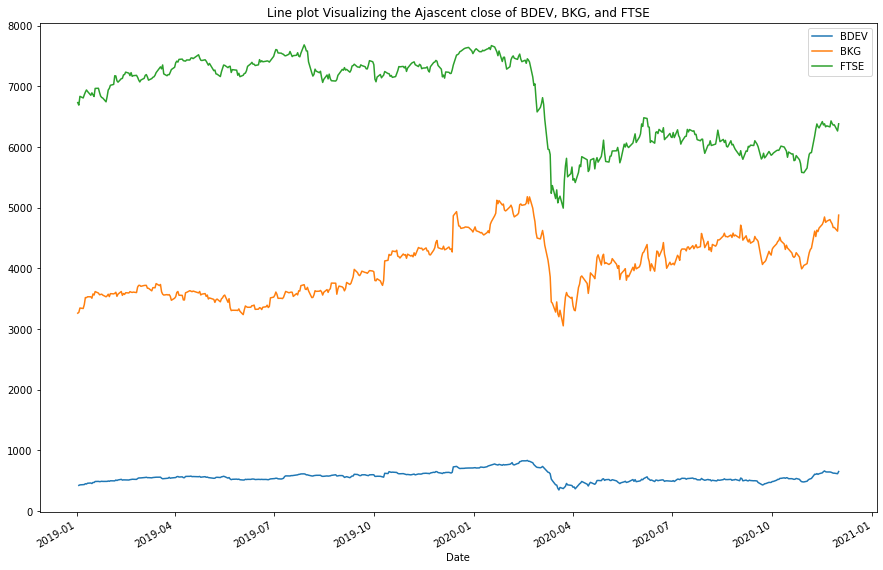

In [287]:

BDEVtr['Adj Close'].plot(figsize=(15,10), label='BDEV')
BKGtr['Adj Close'].plot(label='BKG')
FTSEtr['Adj Close'].plot(label='FTSE')
plt.title('Line plot Visualizing the Ajascent close of BDEV, BKG, and FTSE')
plt.legend()
plt.show()





research and analyse this graph

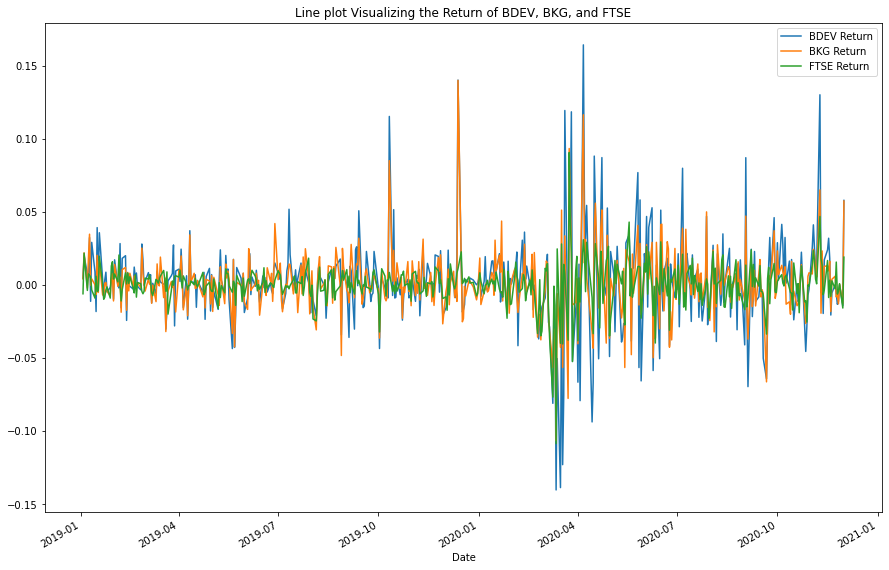

In [157]:

BDEVtr['Return'].plot(figsize=(15,10), label='BDEV Return')
BKGtr['Return'].plot(label='BKG Return')
FTSEtr['Return'].plot(label='FTSE Return')
plt.legend()
plt.title('Line plot Visualizing the Return of BDEV, BKG, and FTSE')
plt.show()

bdev has a both  highest positive and negative return. bdev has its peak of 0.15 in may 2020 and least aroud march
give more details of graph

### Statistics

In [158]:
BDEVtr.describe()

,Adj Close,Return
count,486.000000,486.000000
mean,562.108915,0.001342
std,88.830349,0.029828
min,346.101532,-0.140422
25%,509.069061,-0.010090
50%,540.697418,0.001023
75%,602.774185,0.012400
max,833.604492,0.164195


In [159]:
BKGtr.describe()

,Adj Close,Return
count,487.000000,486.000000
mean,4028.715394,0.001061
std,482.598878,0.021676
min,3052.493408,-0.106722
25%,3596.847778,-0.009836
50%,4026.444824,0.000815
75%,4366.522461,0.010074
max,5182.437988,0.139880


In [160]:
FTSEtr.describe()

,Adj Close,Return
count,487.000000,486.000000
mean,6785.624433,-0.000007
std,683.928666,0.014241
min,4993.899902,-0.108738
25%,6104.800049,-0.005494
50%,7151.100098,0.000682
75%,7353.449951,0.006470
max,7686.600098,0.090530


yOU GET THE BEST RETURN WITH THE HIGHEST MEAN. What can you find by comparing the above tables?
According to the statistics above, the FTSE best return because it has the leasst mean value, followed by BKG, BDEV. therefore the performance of the industry is higher than the market.

In [161]:
# Return to risk BDEV
BDEVtr['Return'].mean()/BDEVtr['Return'].std()

0.04499073157493428

In [162]:
# Return to risk for BKG
BKGtr['Return'].mean()/BKGtr['Return'].std()

0.048960831255552305

In [163]:
# Return to risk for FTSE
FTSEtr['Return'].mean()/BKGtr['Return'].std()

-0.0003412164991185391

# Box Plots <a id="8"></a>

A `box plot` is a way of statistically representing the *distribution* of the data through five main dimensions: 

- **Minimun:** Smallest number in the dataset.
- **First quartile:** Middle number between the `minimum` and the `median`.
- **Second quartile (Median):** Middle number of the (sorted) dataset.
- **Third quartile:** Middle number between `median` and `maximum`.
- **Maximum:** Highest number in the dataset.

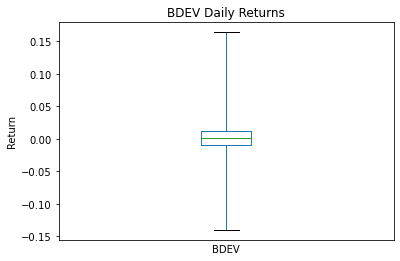

In [164]:
BDEV=BDEVtr.boxplot(column='Return',whis=[0,100],grid=False)

BDEV.set_title("BDEV Daily Returns",fontsize=12)
BDEV.set_xlabel('BDEV', fontsize=10)
BDEV.set_ylabel('Return', fontsize=10)
BDEV.set_xticks([])
plt.show()

We can immediately make a few key observations from the plot above:
1. The minimum number of returns is around -0.14 (min), maximum number is around 0.16 (max), and  median number of returns is around 0.001 (median).
2. 25% of the years for period 2019-01-02 to 2021-01-01 had returns  of ~ -0.009836 or fewer (First quartile).
2. 75% of the years for period 2019-01-02 to 2021-01-01 had returns of ~ 0.012400 fewer (Third quartile).

We can view the actual numbers by calling the `describe()` method on the dataframe.

#### Comparing BDEV, BKG and FTSE daily returns 

In [165]:
Comreturns=pd.concat([BDEVtr['Return'],BKGtr['Return'],FTSEtr['Return']],axis=1)
Comreturns.columns=['BDEV','BKG','FTSE']

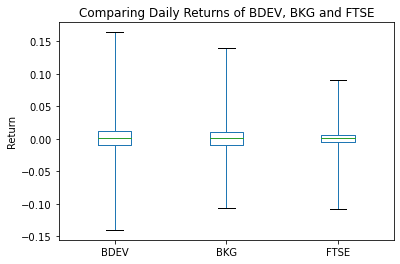

In [166]:
Comreturns.boxplot(whis=[0,100],grid=False)
plt.title('Comparing Daily Returns of BDEV, BKG and FTSE')
plt.ylabel('Return')
plt.show()

We can observe that, while BDEV, BKG and FTSE have around the same median return (~0.001),  BDEV return  range is most spread out than BKG and FTSE. The maximum return fot BKG is ~ 0.14 is higher than the total max return of FTSE (~ 0.09).

If you prefer to create horizontal box plots, you can pass the `vert` parameter in the **plot** function and assign it to *False*. You can also specify a different color in case you are not a big fan of the default red color.

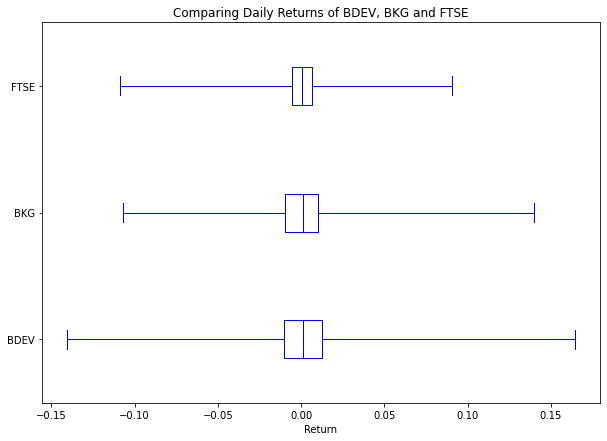

In [167]:
#changing the positions for better preseentation
Comreturns.boxplot(whis=[0,100],grid=False, vert=False, figsize=(10, 7), color='blue')
plt.title('Comparing Daily Returns of BDEV, BKG and FTSE')
plt.xlabel('Return')
plt.show()

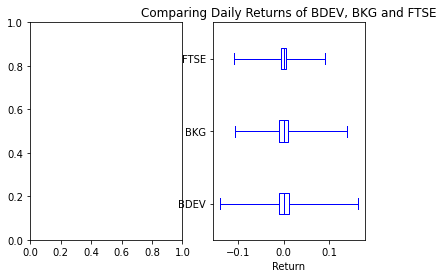

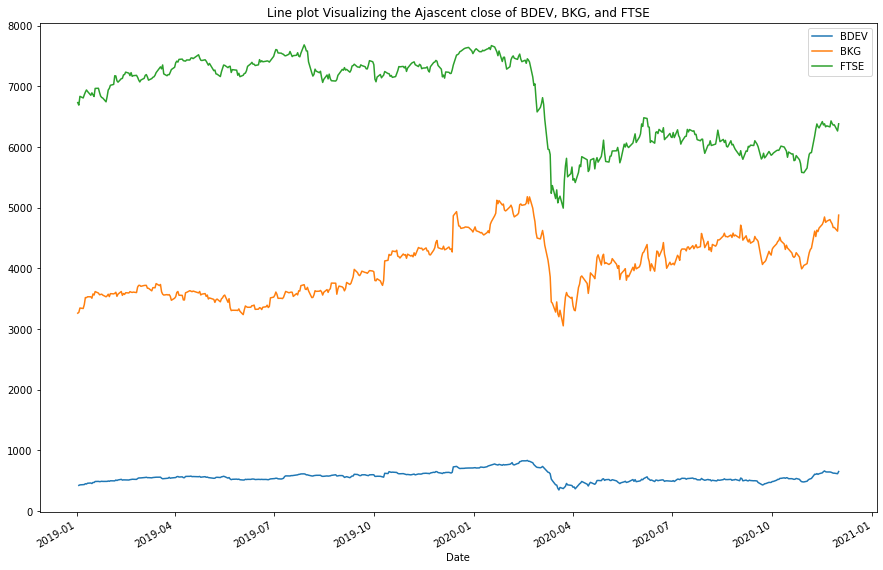

In [168]:

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
#sub plot 1 Box plot 
Comreturns.boxplot(whis=[0,100],grid=False, vert=False, figsize=(10, 7), color='blue')
plt.title('Comparing Daily Returns of BDEV, BKG and FTSE')
plt.xlabel('Return')
plt.show()

#sub plot 2 line plot
BDEVtr['Adj Close'].plot(figsize=(15,10), label='BDEV')
BKGtr['Adj Close'].plot(label='BKG')
FTSEtr['Adj Close'].plot(label='FTSE')
plt.title('Line plot Visualizing the Ajascent close of BDEV, BKG, and FTSE')
plt.legend()
plt.show()

### Histogram

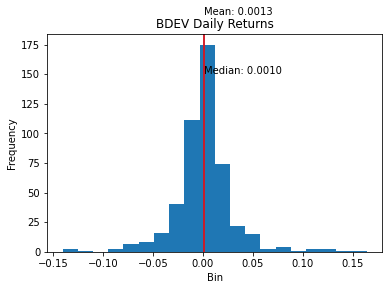

In [169]:
BDEVtr.hist(column='Return',bins=20,grid=False)

plt.title("BDEV Daily Returns",fontsize=12)
plt.xlabel('Bin', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.axvline(BDEVtr['Return'].mean())
plt.text(BDEVtr['Return'].mean()*1.1,200,'Mean: {:,.4f}'.format(BDEVtr['Return'].mean()))

plt.axvline(BDEVtr['Return'].median(),color='r')
plt.text(BDEVtr['Return'].median()*1.2,150,'Median: {:,.4f}'.format(BDEVtr['Return'].median()))

plt.show()

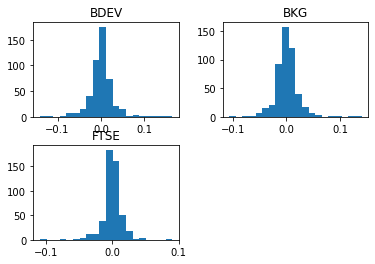

In [170]:
# it's better to draw histograms individually by the above codes

Comreturns.hist(bins=20,grid=False)
plt.show()

## Regression

In [171]:
# The three dataframes have the same column names, we should change the names and merge them together
BDEVtr.columns=['BDEV_Price','BDEV_Return']
BKGtr.columns=['BKG_Price','BKG_Return']
FTSEtr.columns=['FTSE_Price','FTSE_Return']
Overall=pd.concat([BDEVtr,BKGtr,FTSEtr],axis=1)

In [172]:
Overall.head(5)

,BDEV_Price,BDEV_Return,BKG_Price,BKG_Return,FTSE_Price,FTSE_Return
Date,,,,,,
2019-01-02,NaN,NaN,3261.556641,NaN,6734.200195,NaN
2019-01-03,421.311401,0.004543,3274.741943,0.004043,6692.700195,-0.006163
2019-01-04,429.659607,0.019815,3346.321045,0.021858,6837.399902,0.021621
2019-01-07,432.835541,0.007392,3338.786377,-0.002252,6810.899902,-0.003876
2019-01-08,434.922607,0.004822,3400.947266,0.018618,6861.600098,0.007444


In [173]:
Overall.fillna(0)

,BDEV_Price,BDEV_Return,BKG_Price,BKG_Return,FTSE_Price,FTSE_Return
Date,,,,,,
2019-01-02,0.000000,0.000000,3261.556641,0.000000,6734.200195,0.000000
2019-01-03,421.311401,0.004543,3274.741943,0.004043,6692.700195,-0.006163
2019-01-04,429.659607,0.019815,3346.321045,0.021858,6837.399902,0.021621
2019-01-07,432.835541,0.007392,3338.786377,-0.002252,6810.899902,-0.003876
2019-01-08,434.922607,0.004822,3400.947266,0.018618,6861.600098,0.007444
...,...,...,...,...,...,...
2020-11-25,630.096802,-0.013337,4735.171875,-0.006283,6391.100098,-0.006390
2020-11-26,622.965820,-0.011317,4673.300293,-0.013066,6362.899902,-0.004412
2020-11-27,622.965820,0.000000,4675.295898,0.000427,6367.600098,0.000739


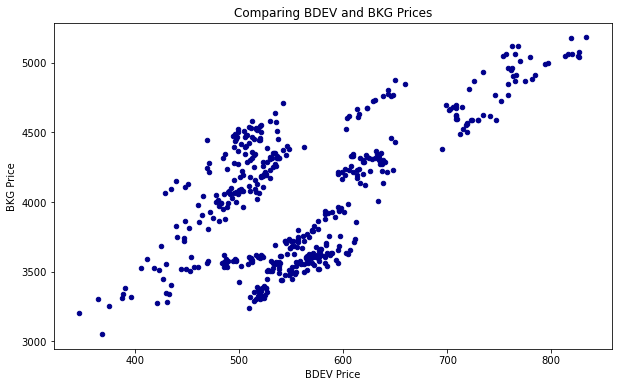

In [174]:
#Generate scatter plot for Prices
Overall.plot(kind='scatter', x='BDEV_Price', y='BKG_Price', figsize=(10,6), color ='darkblue')

#add title and label to axes
plt.title('Comparing BDEV and BKG Prices')
plt.xlabel('BDEV Price')
plt.ylabel('BKG Price')
#show plot
plt.show()

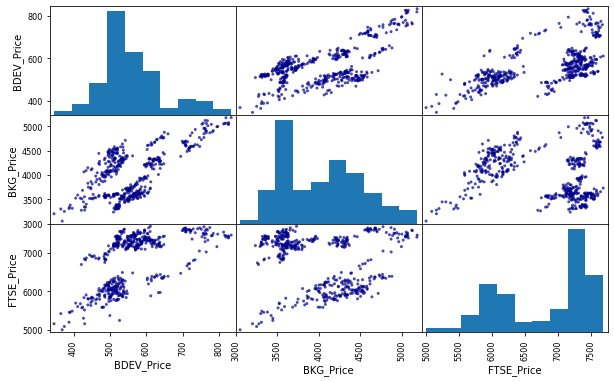

In [175]:
#Plotting scatter plot of company, competitor, and market PRICES
pd.plotting.scatter_matrix(Overall.iloc[:,[0,2,4]], alpha=0.7, figsize=(10,6), color ='darkblue')
plt.show()

Calling the correlation of company, competitor and market prices



In [176]:
#calling the correlation of company, competitor and market PRICES
Overall.iloc[:,[0,2,4]].corr(method='pearson')

,BDEV_Price,BKG_Price,FTSE_Price
BDEV_Price,1.000000,0.633497,0.601156
BKG_Price,0.633497,1.000000,-0.100745
FTSE_Price,0.601156,-0.100745,1.000000


In [177]:
BDEV_BKG_reg=sfa.ols('BDEV_Price ~ BKG_Price', data=Overall).fit()
BDEV_BKG_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             BDEV_Price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     324.4
Date:                Wed, 21 Apr 2021   Prob (F-statistic):           6.88e-56
Time:                        23:21:24   Log-Likelihood:                -2745.0
No. Observations:                 486   AIC:                             5494.
Df Residuals:                     484   BIC:                             5502.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.4098     26.318      3.473      0.001      39.699     143.121
BKG_Price      0.1168      0.006     18.012      0.000       0.104       0.130
==============================================================================
Omnibus:                      189.980   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.384
Skew:                          -0.187   Prob(JB):                     6.86e-07
Kurtosis:                       1.877   Cond. No.                     3.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

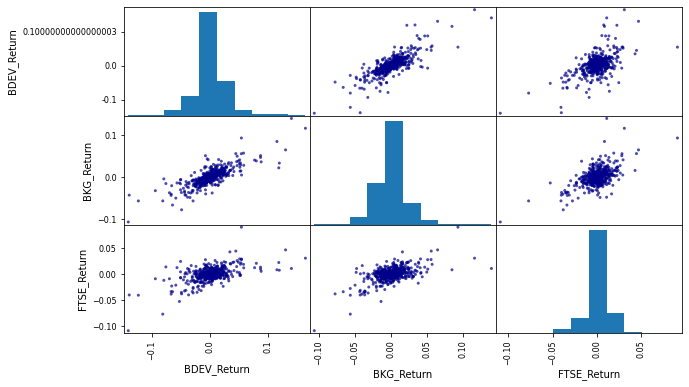

In [178]:
#Plotting scatter plot of company, competitor, and market RETURNS
pd.plotting.scatter_matrix(Overall.iloc[:,[1,3,5]], alpha=0.7, figsize=(10,6), color ='darkblue')
plt.show()

In [179]:
#calling the correlation of company, competitor and market returns
Overall.iloc[:,[1,3,5]].corr(method='pearson')

,BDEV_Return,BKG_Return,FTSE_Return
BDEV_Return,1.000000,0.803682,0.575842
BKG_Return,0.803682,1.000000,0.600036
FTSE_Return,0.575842,0.600036,1.000000


### From the above BDEV and BKG return has the highrst correlation relationship of 0.8 

In [180]:
BDEV_BKG_reg=sfa.ols('BDEV_Return ~ BKG_Return', data=Overall).fit()
BDEV_BKG_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            BDEV_Return   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     882.9
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          3.47e-111
Time:                        23:21:26   Log-Likelihood:                 1270.2
No. Observations:                 486   AIC:                            -2536.
Df Residuals:                     484   BIC:                            -2528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.001      0.209      0.835      -0.001       0.002
BKG_Return     1.1059      0.037     29.713      0.000       1.033       1.179
==============================================================================
Omnibus:                       67.536   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              553.565
Skew:                          -0.233   Prob(JB):                    6.24e-121
Kurtosis:                       8.208   Cond. No.                         46.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

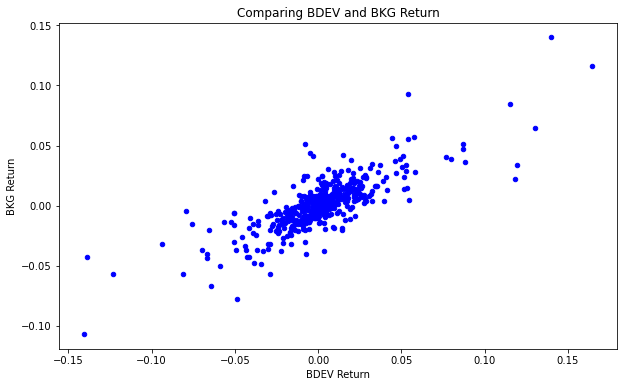

In [181]:
#Visualize scatter plot for BDEV and BKG Return
Overall.plot(kind='scatter', x='BDEV_Return', y='BKG_Return', figsize=(10,6), color ='blue')

#add title and label to axes
plt.title('Comparing BDEV and BKG Return')
plt.xlabel('BDEV Return')
plt.ylabel('BKG Return')
#show plot
plt.show()



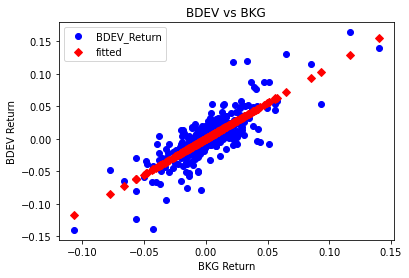

In [182]:
#Regression fitted line
sm.graphics.plot_fit(BDEV_BKG_reg,exog_idx='BKG_Return',vlines=False)
plt.ylabel("BDEV Return")
plt.xlabel("BKG Return")
plt.title("BDEV vs BKG")
plt.show()

In [183]:
#interpretting the table




In [184]:
# Multiple Regression
BDEV_BKG_FTSE_reg=sfa.ols('BDEV_Return ~ BKG_Return + FTSE_Return', data=Overall).fit()
BDEV_BKG_FTSE_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            BDEV_Return   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     468.0
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          9.48e-114
Time:                        23:21:28   Log-Likelihood:                 1279.7
No. Observations:                 486   AIC:                            -2553.
Df Residuals:                     483   BIC:                            -2541.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0003      0.001      0.377      0.706      -0.001       0.002
BKG_Return      0.9852      0.046     21.573      0.000       0.895       1.075
FTSE_Return     0.3064      0.070      4.408      0.000       0.170       0.443
==============================================================================
Omnibus:                       71.225   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              565.361
Skew:                          -0.312   Prob(JB):                    1.71e-123
Kurtosis:                       8.247   Cond. No.                         96.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## refer to my report on  statistics explanation


## Time Series

In [186]:
BDEVte.columns=['BDEV_Price','BDEV_Return']
BKGte.columns=['BKG_Price','BKG_Return']
FTSEte.columns=['FTSE_Price','FTSE_Return']

### Moving Average

In [187]:
ma5=BDEVtr.rolling(5).mean()

In [188]:
ma20=BDEVtr.rolling(20).mean()

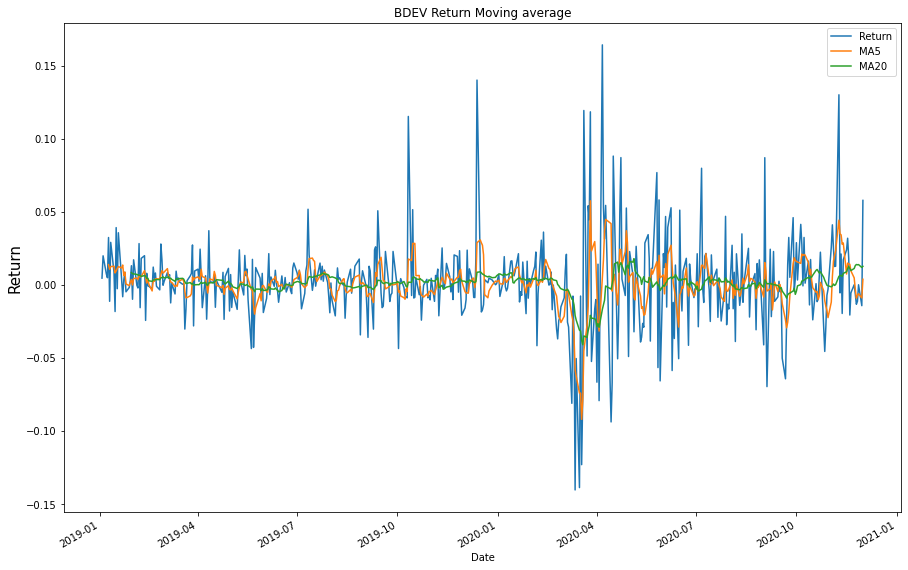

In [264]:
BDEVtr['BDEV_Return'].plot(figsize=(15,10), title= 'BDEV Return Moving average', label='Return')
ma5['BDEV_Return'].plot(label='MA5')
ma20['BDEV_Return'].plot(label='MA20')
plt.legend()
plt.ylabel('Return',fontsize=15)
plt.show()

The stock return wasvery stable until March 2020, where it becamee very volatile due to the covid 19 pandemic.

In [267]:
BDEVma5fcsts=pd.Series([ma5['BDEV_Return'][-1]]*20)
BDEVma5fcsts.index=BDEVte.index

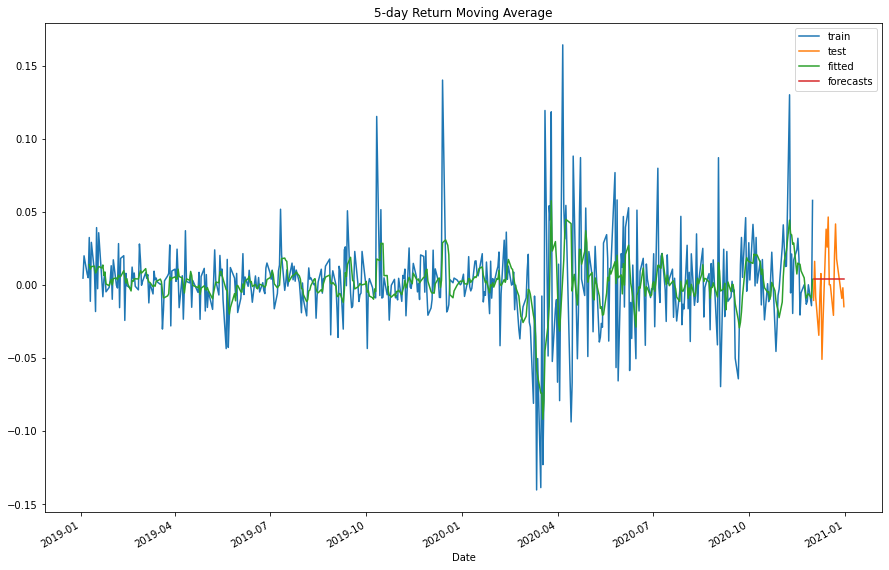

In [269]:
#Including fitted lines

BDEVtr['BDEV_Return'].plot(figsize=(15,10),label='train',title='5-day Return Moving Average')
BDEVte['BDEV_Return'].plot(label='test')
ma5['BDEV_Return'].plot(label='fitted')
BDEVma5fcsts.plot(label='forecasts')
plt.legend()
plt.show()

In [192]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Return'],BDEVma5fcsts)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Return'],BDEVma5fcsts))
                         )

MAE: 0.0207 
MSE: 0.0006


### Single Exponential Smoothing


In [253]:
BDEVses=SES(BDEVtr['BDEV_Return'],initialization_method="estimated").fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [254]:
BDEVsesfcsts=BDEVses.forecast(20)
BDEVsesfcsts.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


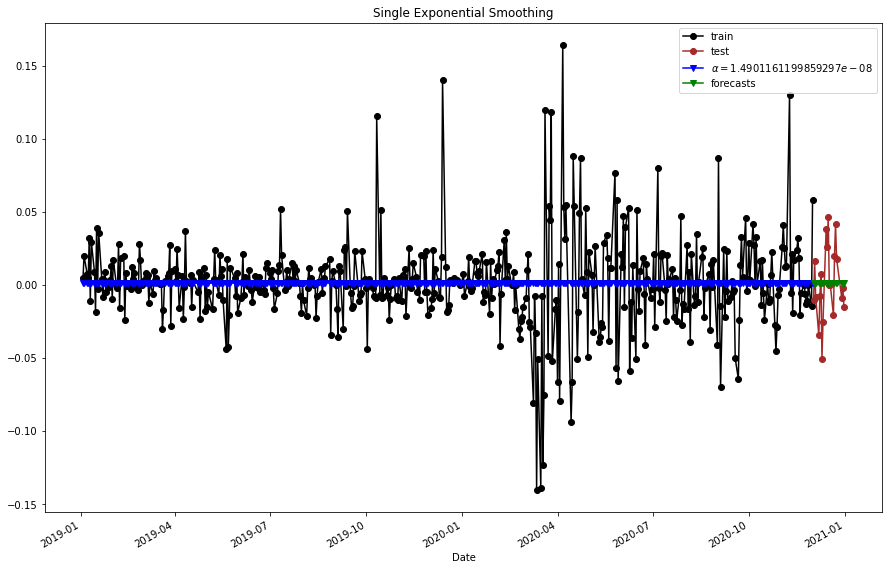

In [255]:
BDEVtr['BDEV_Return'].plot(figsize=(15,10),marker='o',color='black',label='train',title='Single Exponential Smoothing')
BDEVte['BDEV_Return'].plot(marker='o',color='brown',label='test')
BDEVses.fittedvalues.plot(marker='v', color='blue',label=r'$\alpha=%s$'%BDEVses.model.params['smoothing_level'])
BDEVsesfcsts.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()



In [257]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Return'],BDEVsesfcsts)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Return'],BDEVsesfcsts))
)

MAE: 0.0202 
MSE: 0.0006


### Double Exponential Smoothing


In [202]:
BDEVdes=DES(BDEVtr['BDEV_Return'],initialization_method="estimated").fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [203]:
BDEVdesfcsts=BDEVdes.forecast(20)
BDEVdesfcsts.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


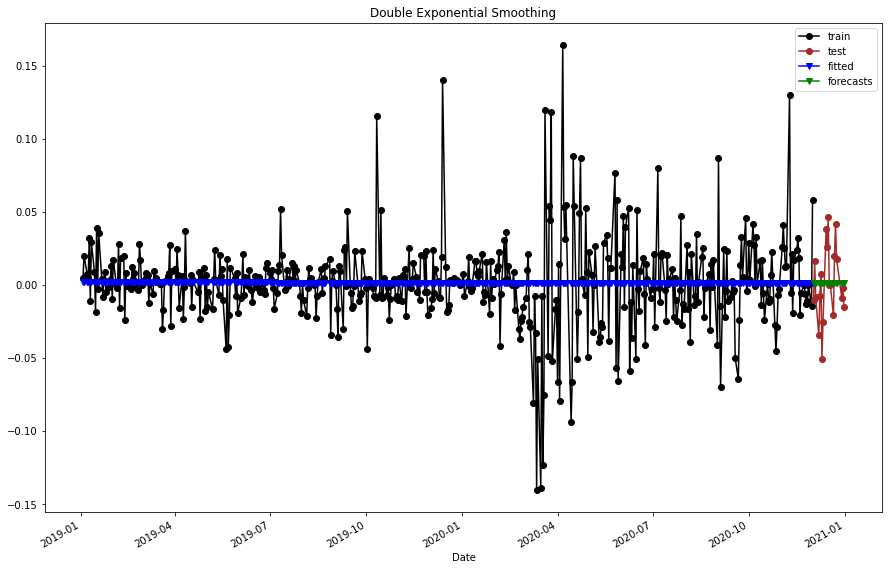

In [204]:
BDEVtr['BDEV_Return'].plot(figsize=(15,10),marker='o',color='black',label='train',title='Double Exponential Smoothing')
BDEVte['BDEV_Return'].plot(marker='o',color='brown',label='test')
BDEVdes.fittedvalues.plot(marker='v', color='blue',label='fitted')
BDEVdesfcsts.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [205]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Return'],BDEVdesfcsts)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Return'],BDEVdesfcsts))
)

MAE: 0.0201 
MSE: 0.0006


### Holt's Winters (Addictive)

In [258]:
BDEVtesa=TES(BDEVtr['BDEV_Return'],seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
BDEVtesfcstsa=BDEVtesa.forecast(20)
BDEVtesfcstsa.index=BDEV
te.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ValueError: Data must be positive.

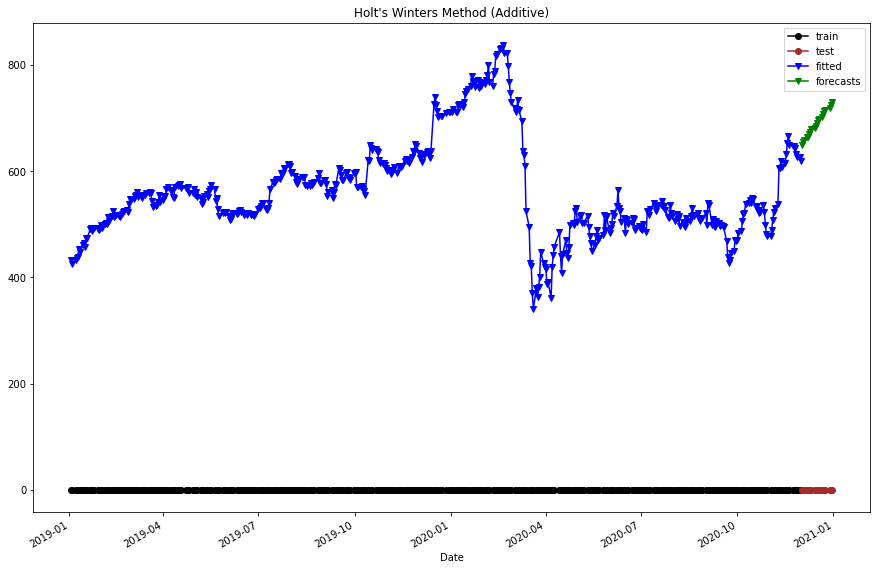

In [259]:
BDEVtr['BDEV_Return'].plot(figsize=(15,10),marker='o',color='black',label='train',title="Holt's Winters Method (Additive)")
BDEVte['BDEV_Return'].plot(marker='o',color='brown',label='test')
BDEVtesa.fittedvalues.plot(marker='v', color='blue',label='fitted')
BDEVtesfcstsa.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [260]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Return'],BDEVtesfcstsa)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Return'],BDEVtesfcstsa))
)

MAE: 688.6091 
MSE: 474,755.3926


### Holt's Winters (Multiplicative)

In [261]:
BDEVtesm=TES(BDEVtr['BDEV_Return'],seasonal_periods=4, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
BDEVtesfcstsm=BDEVtesm.forecast(20)
BDEVtesfcstsm.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

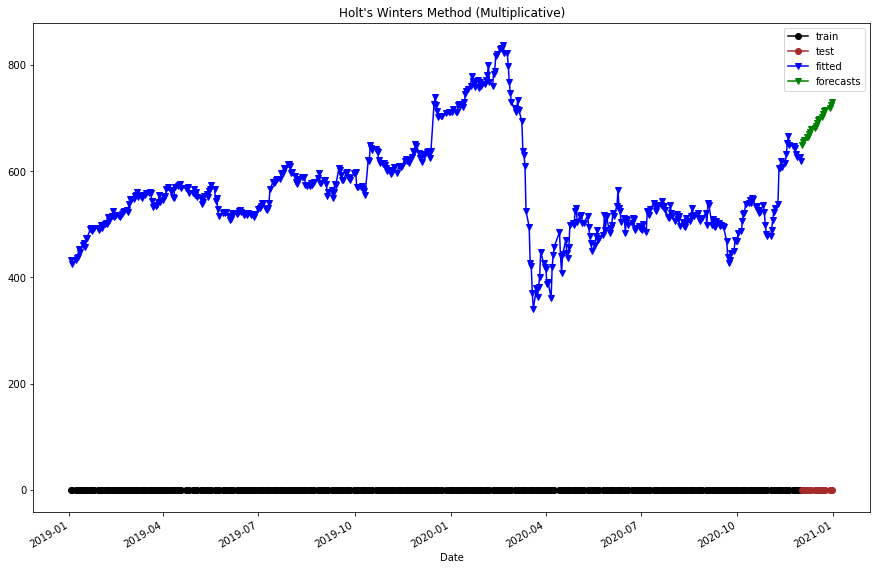

In [262]:
BDEVtr['BDEV_Return'].plot(figsize=(15,10),marker='o',color='black',label='train',title="Holt's Winters Method (Multiplicative)")
BDEVte['BDEV_Return'].plot(marker='o',color='brown',label='test')
BDEVtesm.fittedvalues.plot(marker='v', color='blue',label='fitted')
BDEVtesfcstsm.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [263]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Return'],BDEVtesfcstsm)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Return'],BDEVtesfcstsm))
)

MAE: 688.6145 
MSE: 474,762.8504


### Time Series for Price

### Moving Average

In [222]:
ma5=BDEVtr.rolling(5).mean()

In [223]:
ma20=BDEVtr.rolling(20).mean()

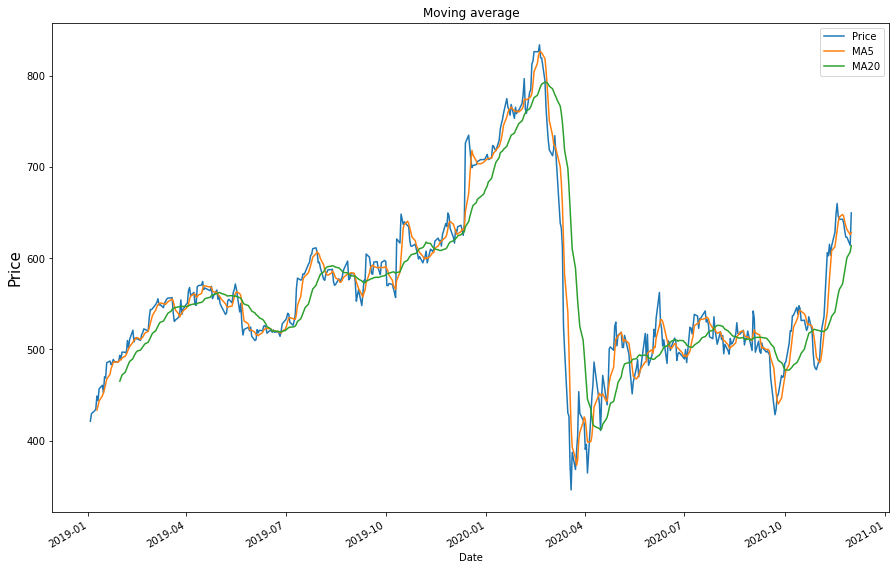

In [224]:
BDEVtr['BDEV_Price'].plot(figsize=(15,10), title= 'Moving average', label='Price')
ma5['BDEV_Price'].plot(label='MA5')
ma20['BDEV_Price'].plot(label='MA20')
plt.legend()
plt.ylabel('Price',fontsize=15)
plt.show()

In [225]:
BDEVma5fcsts=pd.Series([ma5['BDEV_Price'][-1]]*20)
BDEVma5fcsts.index=BDEVte.index

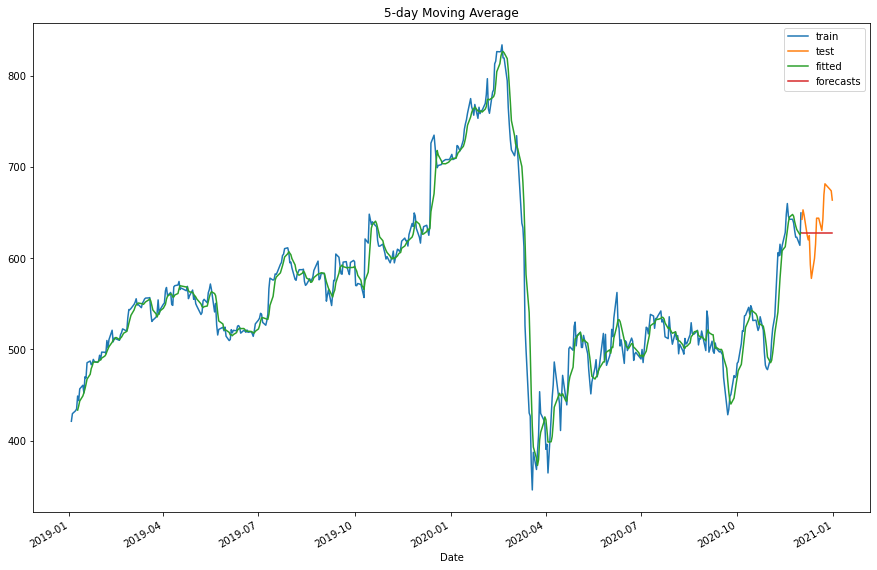

In [228]:
BDEVtr['BDEV_Price'].plot(figsize=(15,10),label='train',title='5-day Moving Average')
BDEVte['BDEV_Price'].plot(label='test')
ma5['BDEV_Price'].plot(label='fitted')
BDEVma5fcsts.plot(label='forecasts')
plt.legend()
plt.show()

In [229]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Price'],BDEVma5fcsts)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Price'],BDEVma5fcsts))
                         )

MAE: 24.3739 
MSE: 857.3291


### Single Exponential Smoothing

In [230]:
BDEVses=SES(BDEVtr['BDEV_Price'],initialization_method="estimated").fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [231]:
BDEVsesfcsts=BDEVses.forecast(20)
BDEVsesfcsts.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


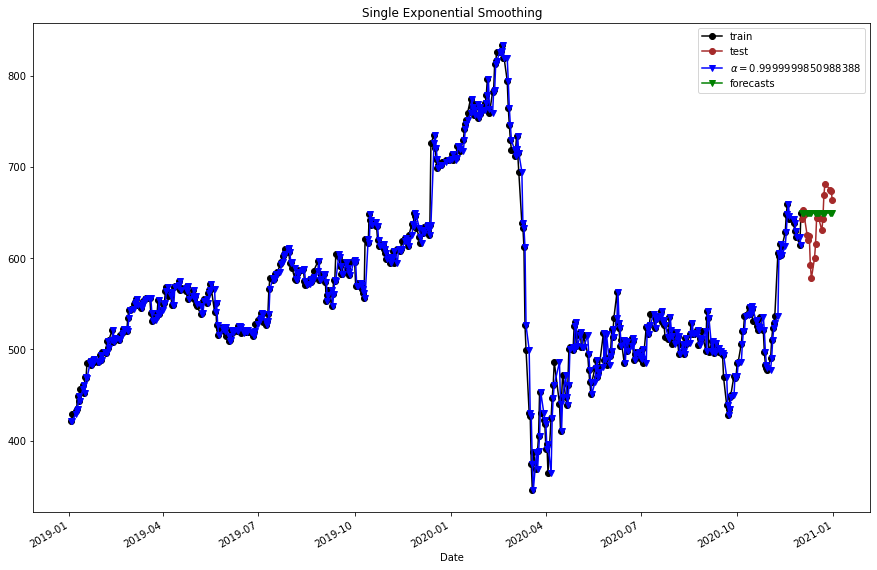

In [233]:
BDEVtr['BDEV_Price'].plot(figsize=(15,10),marker='o',color='black',label='train',title='Single Exponential Smoothing')
BDEVte['BDEV_Price'].plot(marker='o',color='brown',label='test')
BDEVses.fittedvalues.plot(marker='v', color='blue',label=r'$\alpha=%s$'%BDEVses.model.params['smoothing_level'])
BDEVsesfcsts.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [234]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Price'],BDEVsesfcsts)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Price'],BDEVsesfcsts))
)

MAE: 23.1260 
MSE: 875.7185


### Double Exponential Smoothing

In [235]:
BDEVdes=DES(BDEVtr['BDEV_Price'],initialization_method="estimated").fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [236]:
BDEVdesfcsts=BDEVdes.forecast(20)
BDEVdesfcsts.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


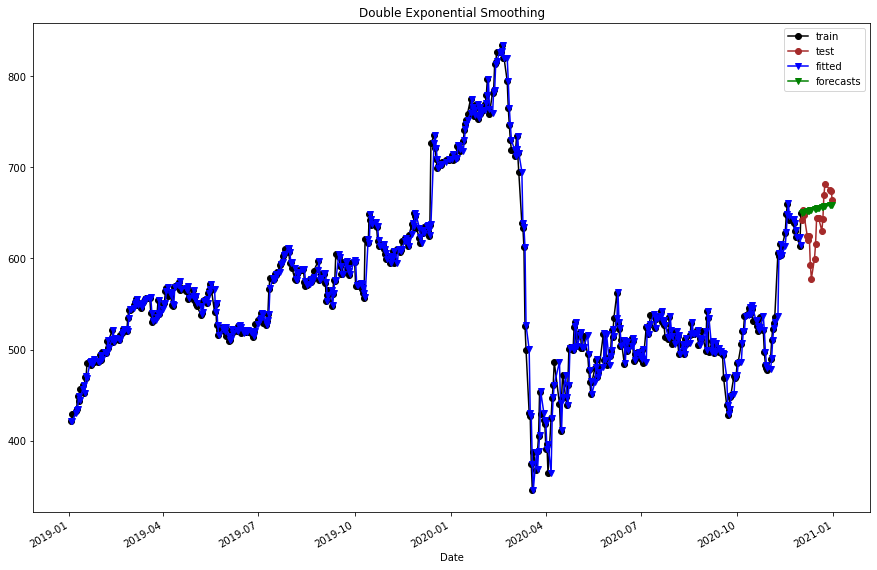

In [237]:
BDEVtr['BDEV_Price'].plot(figsize=(15,10),marker='o',color='black',label='train',title='Double Exponential Smoothing')
BDEVte['BDEV_Price'].plot(marker='o',color='brown',label='test')
BDEVdes.fittedvalues.plot(marker='v', color='blue',label='fitted')
BDEVdesfcsts.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [238]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Price'],BDEVdesfcsts)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Price'],BDEVdesfcsts))
)

MAE: 23.7379 
MSE: 939.3185


### Holt's Winters (Additive)


In [240]:
BDEVtesa=TES(BDEVtr['BDEV_Price'],seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
BDEVtesfcstsa=BDEVtesa.forecast(20)
BDEVtesfcstsa.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


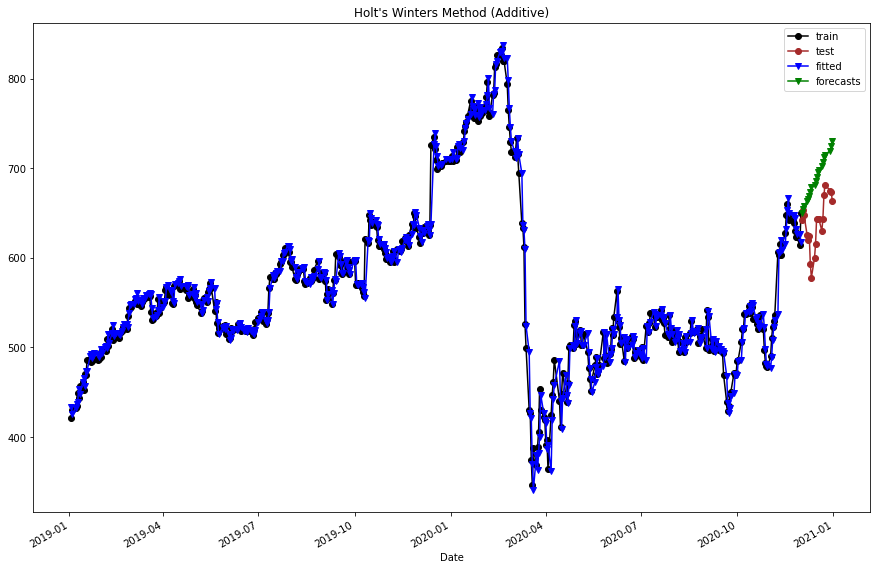

In [243]:
BDEVtr['BDEV_Price'].plot(figsize=(15,10),marker='o',color='black',label='train',title="Holt's Winters Method (Additive)")
BDEVte['BDEV_Price'].plot(marker='o',color='brown',label='test')
BDEVtesa.fittedvalues.plot(marker='v', color='blue',label='fitted')
BDEVtesfcstsa.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [245]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Price'],BDEVtesfcstsa)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Price'],BDEVtesfcstsa))
)

MAE: 50.3231 
MSE: 3,143.8824


### Holt's Winters (Multiplicative)


In [247]:
BDEVtesm=TES(BDEVtr['BDEV_Price'],seasonal_periods=4, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
BDEVtesfcstsm=BDEVtesm.forecast(20)
BDEVtesfcstsm.index=BDEVte.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


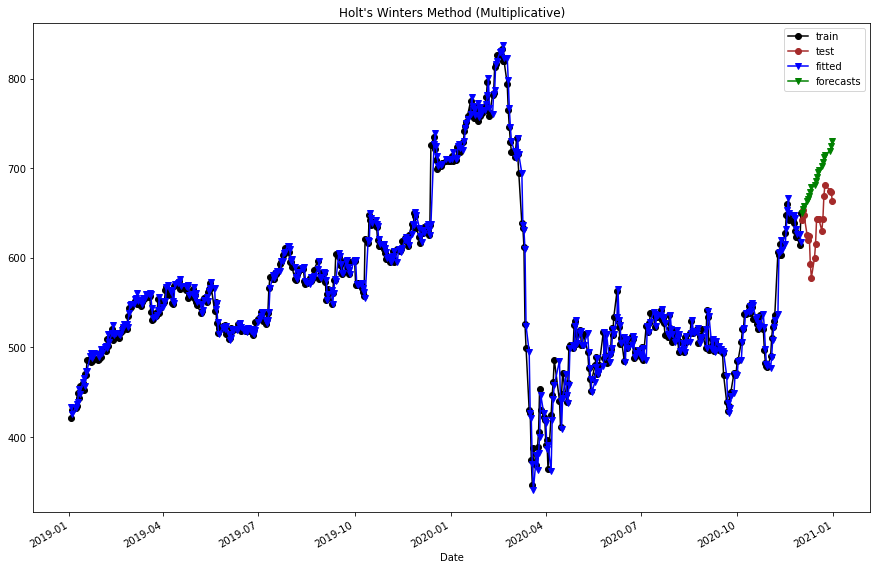

In [248]:
BDEVtr['BDEV_Price'].plot(figsize=(15,10),marker='o',color='black',label='train',title="Holt's Winters Method (Multiplicative)")
BDEVte['BDEV_Price'].plot(marker='o',color='brown',label='test')
BDEVtesm.fittedvalues.plot(marker='v', color='blue',label='fitted')
BDEVtesfcstsm.plot(marker='v', color='green',label='forecasts')
plt.legend()
plt.show()

In [249]:
print(
    'MAE: {:,.4f}'.format(MAE(BDEVte['BDEV_Price'],BDEVtesfcstsm)),
    '\nMSE: {:,.4f}'.format(MSE(BDEVte['BDEV_Price'],BDEVtesfcstsm))
)

MAE: 50.3284 
MSE: 3,144.4479


From Price time series the moving average has the least moving average error. meaning it has the best forcasting model.

From return time series the double exponential smoothing has the least moving average error. meaning it has the best forcasting model.
